# Chatbot
- [reference] https://python.langchain.com/v0.2/docs/tutorials/chatbot/

## Quickstart

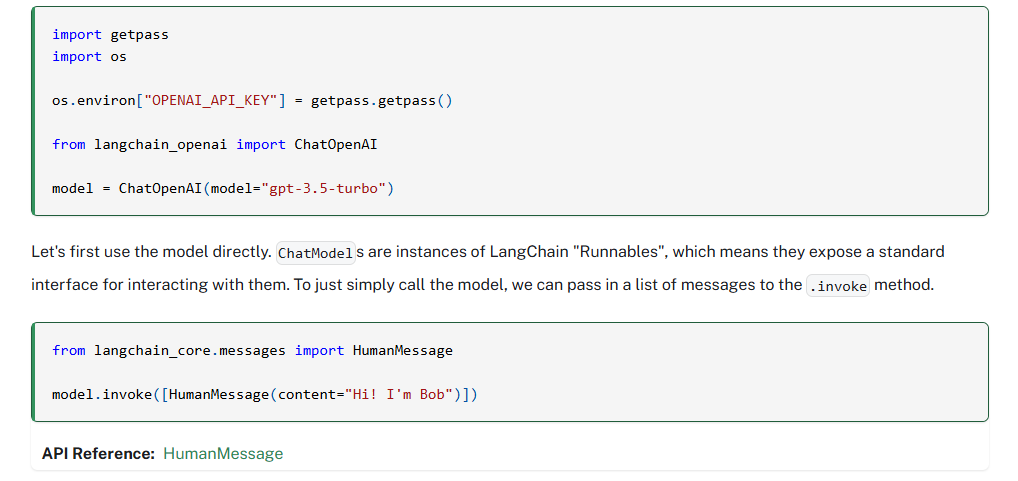

In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv


load_dotenv()

model = ChatOpenAI(model='gpt-4.1-nano')

ai_message = model.invoke([HumanMessage(content="Hi! I'm Bob")])

ai_message.content

'Hello, Bob! How can I assist you today?'

In [2]:
ai_message_02 = model.invoke('What is my name?')
ai_message_02.content

"I'm sorry, but I don't know your name. How can I assist you today?"

In [3]:
ai_message_03 = model.invoke([HumanMessage('What is my name?')])
ai_message_03.content

"I'm sorry, but I don't know your name."

In [4]:
from langchain_core.messages import AIMessage
ai_message_04 = model.invoke(
    [
    HumanMessage(content='Hi I am Bob'),
    AIMessage(content='hellow Bob! How can I assist you today?'),
    HumanMessage(content='What is my name?')
    ]
) 
ai_message_04.content

'Your name is Bob.'

## Message History

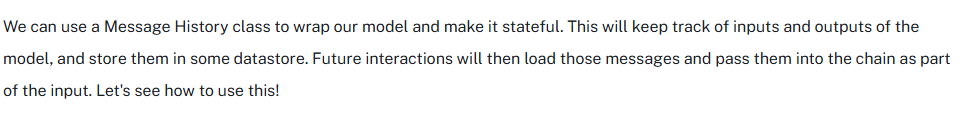

In [5]:
from langchain_core.chat_history import(
    BaseChatMessageHistory,
    InMemoryChatMessageHistory,
)
from langchain_core.runnables.history import RunnableWithMessageHistory

store = {}

def get_session_history(session_id:str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
    return store[session_id]

with_message_history = RunnableWithMessageHistory(model,get_session_history)

config = {'configurable': {'session_id': 'abc'}}

response = with_message_history.invoke(
    [HumanMessage(content='Hi! I am Bob')],
    config=config
)

response.content

'Hello, Bob! How can I assist you today?'

In [6]:
response = with_message_history.invoke(
    [HumanMessage(content='What is my name?')],
    config=config
)

response.content

'Your name is Bob!'

In [7]:
config = {'configurable': {'session_id': 'abc2'}}

response = with_message_history.invoke(
    [HumanMessage(content='What is my name?')],
    config=config
)

response.content

"I'm sorry, but I don't know your name."

---

## Prompt templates

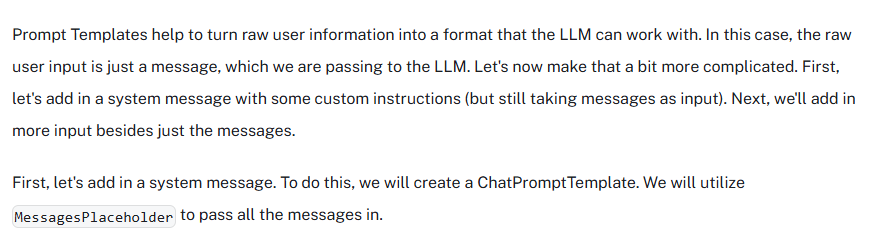

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ('system','You are a helpful assistant. '
        'Answer all questions to the best of your ability.'),
         MessagesPlaceholder(variable_name='messages'),
    ]
)

chain = prompt | model

response = chain.invoke({"messages": [HumanMessage(content="hi! I'm Bob")]})

response.content

'Hello, Bob! Nice to meet you. How can I assist you today?'

In [9]:
with_message_history = RunnableWithMessageHistory(chain, get_session_history)

config = {'configurable': {'session_id':'abc3'}}

response = with_message_history.invoke(
    [HumanMessage(content='Hi! I am Jim')],
    config=config
)

response.content

'Hi Jim! Nice to meet you. How can I assist you today?'

In [10]:
response = with_message_history.invoke(
    [HumanMessage(content='What is my name?')],
    config=config
)

response.content

'Your name is Jim.'

In [11]:
for message in get_session_history('abc3').messages:
    print(f'[{message.type.upper()}]:{message.content}')

[HUMAN]:Hi! I am Jim
[AI]:Hi Jim! Nice to meet you. How can I assist you today?
[HUMAN]:What is my name?
[AI]:Your name is Jim.


In [12]:
prompt = ChatPromptTemplate.from_messages(
    [
        ('system', 'You are helpful assistant. Answer all question to the best of your ability in {language}.',),
        MessagesPlaceholder(variable_name='messages') 
    ])

chain = prompt | model

- Let's now wrap this more complicated chain in a Message History class. 
- This time, because there are multiple keys in the input, we need to specify the correct key to use to save the chat history.

In [13]:
response = chain.invoke(
    {"messages": [HumanMessage(content="hi! I'm bob")], "language": "Spanish"}
)

response.content

'¡Hola, Bob! Encantado de saludarte. ¿En qué puedo ayudarte hoy?'

In [14]:
with_message_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key='messages',
)

config = {'configurable': {'session_id': 'abc4'}}

response = with_message_history.invoke(
    {'messages': [HumanMessage(content='Hi! I am Todd')], 'language': 'Spanish'},
    config=config,
)

response.content

'¡Hola, Todd! Mucho gusto en conocerte. ¿En qué puedo ayudarte hoy?'

In [15]:
response = with_message_history.invoke(
    {'messages': [HumanMessage(content='Whats my name?')], 'language': 'Spanish'},
    config=config,
)

response.content

'Tu nombre es Todd.'

---

## Managing Conversation History

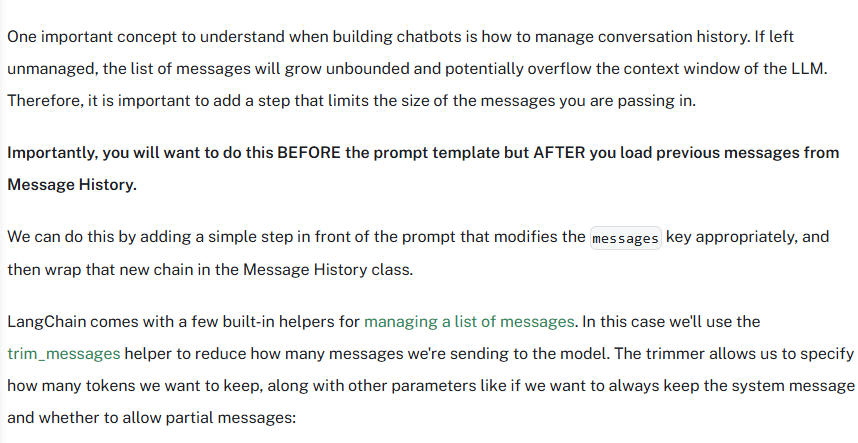

In [16]:
from langchain_core.messages import SystemMessage, trim_messages

model=ChatOpenAI(model='gpt-4o')

trimmer = trim_messages(
    max_tokens=65,
    strategy="last",
    token_counter=model,
    include_system=True,
    allow_partial=False,
    start_on="human",
)

messages = [
    SystemMessage(content='You are a good assistant'),
    HumanMessage(content='Hi! I am Bob'),
    AIMessage(content='Hi!'),
    HumanMessage(content='I like vanilla ice cream'),
    AIMessage(content='nice'),
    HumanMessage(content='Whats 2 + 2'),
    AIMessage(content='4'),
    HumanMessage(content='Thanks'),
    AIMessage(content='No problem!'),
    HumanMessage(content='Having fun?'),
    AIMessage(content='Yes!'),
]

trimmer.invoke(messages)

[SystemMessage(content='You are a good assistant', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Whats 2 + 2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Thanks', additional_kwargs={}, response_metadata={}),
 AIMessage(content='No problem!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Having fun?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Yes!', additional_kwargs={}, response_metadata={})]

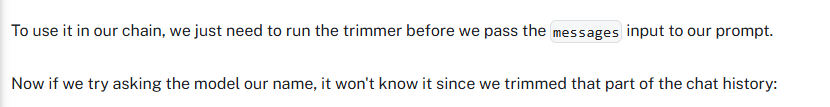

In [17]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

chain = (
    RunnablePassthrough.assign(messages=itemgetter("messages") | trimmer)
    | prompt
    | model
)

response = chain.invoke(
    {
        "messages": messages + [HumanMessage(content="what's my name?")],
        "language": "English",
    }
)
response.content

"I'm sorry, but I don't have access to your personal information, so I don't know your name. "

In [18]:
response = chain.invoke(
    {'messages': messages + [HumanMessage(content='What math problem did i ask')],
    'language': 'English',}
)

response.content

'You asked, "What\'s 2 + 2?"'

In [19]:
with_message_history = RunnableWithMessageHistory(
    chain,
    get_session_history,
    input_messages_key="messages",
)

config = {"configurable": {"session_id": "abc5"}}

response = with_message_history.invoke(
    {"messages": messages + [HumanMessage(content="whats my name?")],
    "language": "English",},
    config=config,
)

response.content

"I'm sorry, but I don't have access to personal data about you unless you provide it in our conversation. If you tell me your name, I'll be happy to address you by it!"

In [20]:
for message in get_session_history('abc5').messages:
    print(f'[{message.type.upper()}]:{message.content}')

[SYSTEM]:You are a good assistant
[HUMAN]:Hi! I am Bob
[AI]:Hi!
[HUMAN]:I like vanilla ice cream
[AI]:nice
[HUMAN]:Whats 2 + 2
[AI]:4
[HUMAN]:Thanks
[AI]:No problem!
[HUMAN]:Having fun?
[AI]:Yes!
[HUMAN]:whats my name?
[AI]:I'm sorry, but I don't have access to personal data about you unless you provide it in our conversation. If you tell me your name, I'll be happy to address you by it!


In [21]:
response = with_message_history.invoke(
    {'messages': [HumanMessage(content='What math problem did i ask?')],
    'language': 'English',},
config=config,
)
response.content

"I'm sorry, but I can't determine what math problem you previously asked, as I don't have the capability to access prior interactions or external data. Could you please provide the math problem again, and I'll do my best to help you with it?"

---

## Streaming

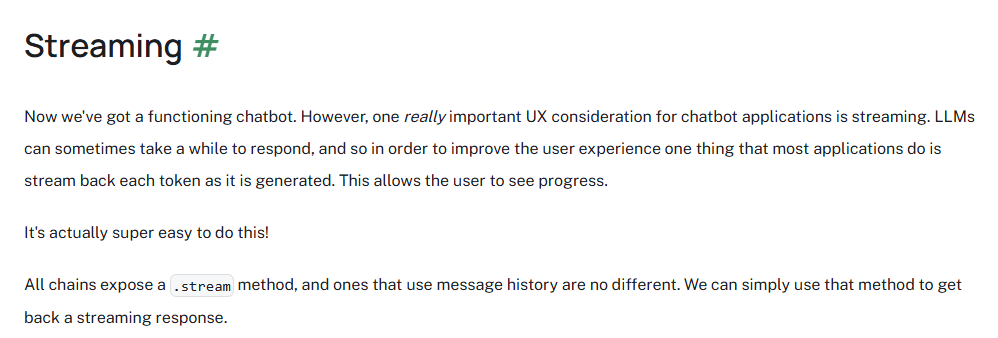

In [22]:
config = {'configurable': {'session_id': 'abc6'}}
for r in with_message_history.stream(
    {
        'messages': [HumanMessage(content='Hi! I am Todd. Tell me a joke.')],
        'language': 'English',
},
config=config,
):
    print(r.content, end="|")

|Hi| Todd|!| Here's| a| joke| for| you|:| Why| don't| skeleton|s| fight| each| other|?| They| don't| have| the| guts|!||